In [3]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.image import resize_with_pad
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Dropout, LeakyReLU, MaxPooling2D, UpSampling2D

In [4]:
BASE_IMAGE_PATH = 'Images'
BASE_LABELS_PATH = 'Labels'
TARGET_IMAGE_SIZE = (256, 256)
LEARNING_RATE = 0.0001
BATCH_SIZE = 16
EPOCHS = 50
VAL_SPLIT = 0.2

In [5]:
image_data = []
image_labels = []

image_count = len(os.listdir(BASE_IMAGE_PATH))

for i in range(1, image_count + 1):
    img = load_img(os.path.join(BASE_IMAGE_PATH, str(i) + '.jpeg'))
    img = img_to_array(img, dtype = 'uint8')
    image_data.append(img)
    
    label_mask = np.zeros((*img.shape[:2], 1))
    
    with open(os.path.join(BASE_LABELS_PATH, str(i) + '.txt'), 'r') as label_file:
        l_count = int(label_file.readline())
        
        for i in range(l_count):
            box = list(map(int, label_file.readline().split()))
            label_mask[box[1]:box[3], box[0]:box[2]] = 1.0
        
    image_labels.append(label_mask)

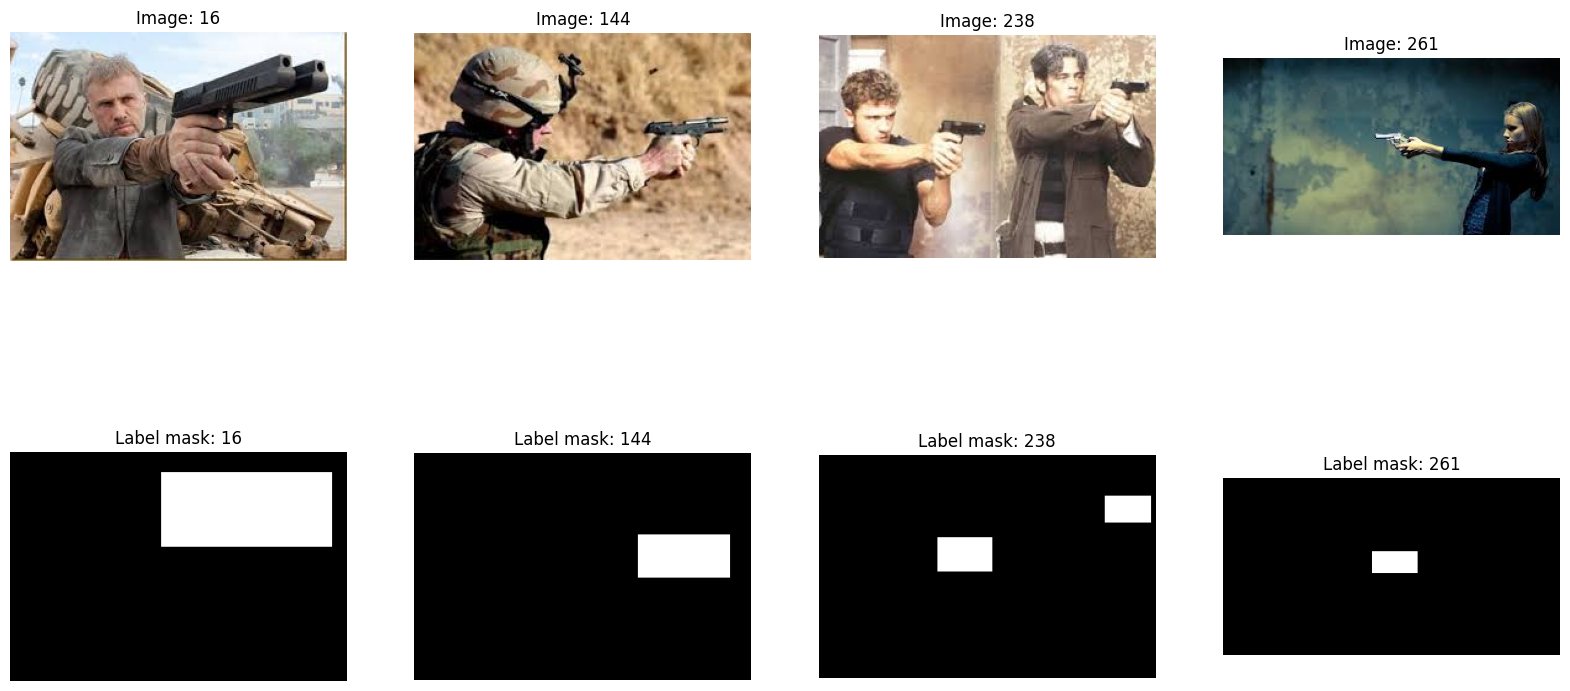

In [6]:
plt.subplots(nrows = 2, ncols = 4, figsize = (20, 10))

for i, img_index in enumerate(np.random.randint(0, image_count, size = 4)):
    plt.subplot(2, 4, i + 1)
    plt.axis(False)
    plt.grid(False)
    plt.title(f'Image: {img_index}')
    plt.imshow(image_data[img_index])
    
    plt.subplot(2, 4, i + 5)
    plt.axis(False)
    plt.grid(False)
    plt.title(f'Label mask: {img_index}')
    plt.imshow(image_labels[img_index], cmap = 'gray')
plt.show()

In [7]:
for i in range(image_count):
    image_data[i] = resize_with_pad(image_data[i], *TARGET_IMAGE_SIZE).numpy() / 255.0
    image_labels[i] = resize_with_pad(image_labels[i], *TARGET_IMAGE_SIZE).numpy()

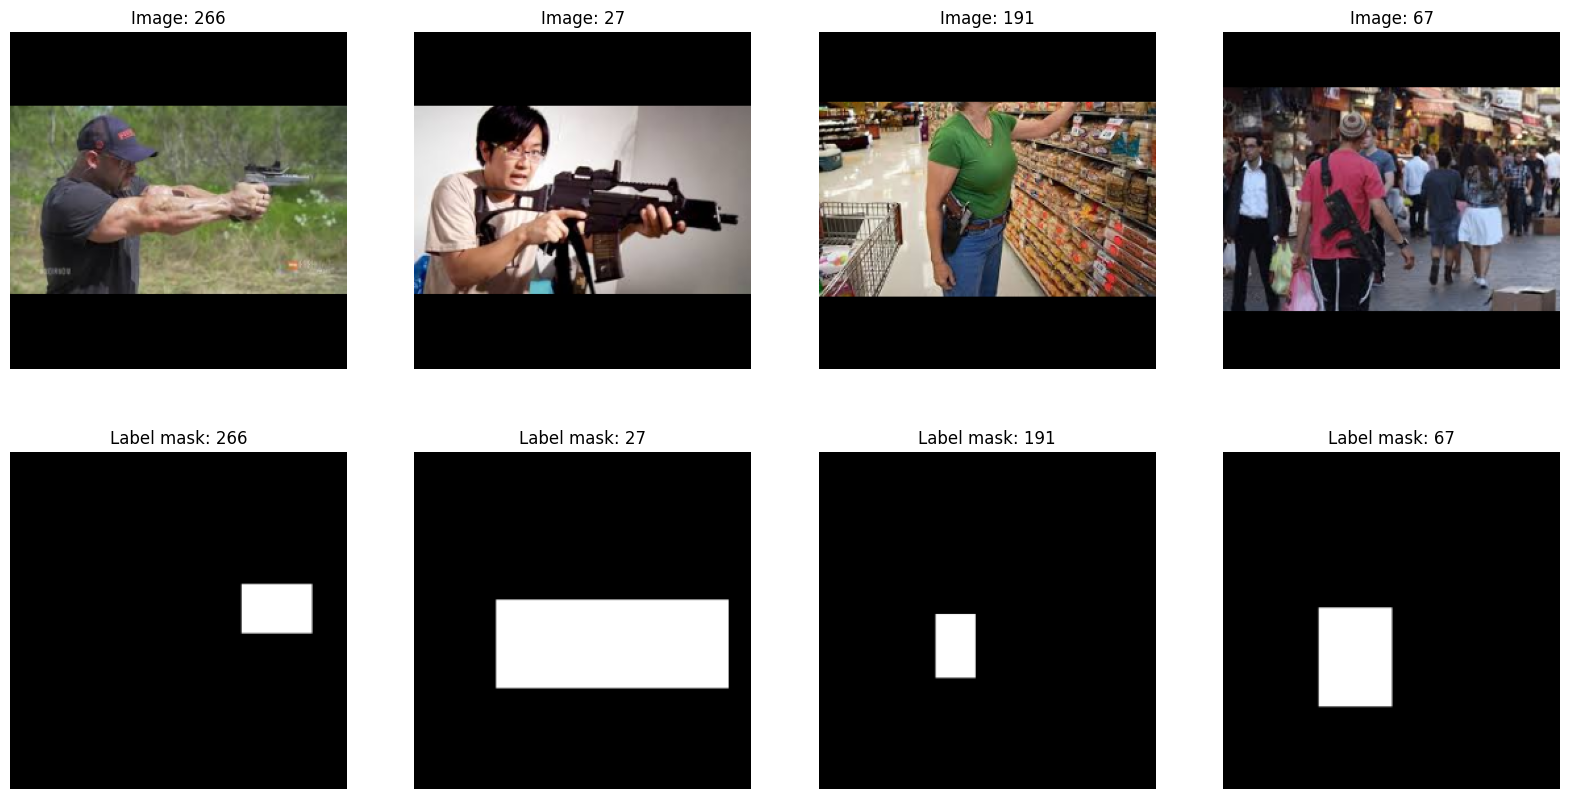

In [8]:
plt.subplots(nrows = 2, ncols = 4, figsize = (20, 10))

for i, img_index in enumerate(np.random.randint(0, image_count, size = 4)):
    plt.subplot(2, 4, i + 1)
    plt.axis(False)
    plt.grid(False)
    plt.title(f'Image: {img_index}')
    plt.imshow(image_data[img_index])
    
    plt.subplot(2, 4, i + 5)
    plt.axis(False)
    plt.grid(False)
    plt.title(f'Label mask: {img_index}')
    plt.imshow(image_labels[img_index], cmap = 'gray')
plt.show()

In [9]:
image_data = np.array(image_data)
image_labels = np.array(image_labels)

In [10]:
def weighted_bce(y_true, y_pred):
    LOSS_WEIGHT = 8
    loss_ones = LOSS_WEIGHT * y_true * tf.math.log(y_pred + 1e-7)
    loss_zeros = (1 - y_true) * tf.math.log(1 - y_pred + 1e-7)
    loss = - loss_ones - loss_zeros
    return tf.reduce_mean(loss)

In [11]:
model = Sequential([
    Conv2D(32, 5, padding = 'same', input_shape = (*TARGET_IMAGE_SIZE, 3), activation = LeakyReLU()),
    MaxPooling2D(),

    Conv2D(64, 4, padding = 'same', activation = LeakyReLU()),
    MaxPooling2D(),
    
    Conv2D(128, 3, padding = 'same', activation = LeakyReLU()),
    Dropout(0.1),
    
    UpSampling2D(),
    Conv2D(64, 4, padding = 'same', activation = LeakyReLU()),

    UpSampling2D(),
    Conv2D(32, 5, padding = 'same', activation = LeakyReLU()),

    Dropout(0.1),
    Conv2D(1, 3, padding = 'same', activation = 'sigmoid'),
])

model.compile(optimizer = Adam(LEARNING_RATE), loss = weighted_bce)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      32832     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 dropout (Dropout)           (None, 64, 64, 128)       0

In [12]:
%%time

history = model.fit(image_data, image_labels, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_split = VAL_SPLIT, verbose = 1)

Epoch 1/50
17/17 [==============================] - 172s 10s/step - loss: 1.1081 - val_loss: 1.0746
Epoch 2/50
17/17 [==============================] - 168s 10s/step - loss: 1.0942 - val_loss: 1.0565
Epoch 3/50
17/17 [==============================] - 205s 12s/step - loss: 1.0542 - val_loss: 0.9653
Epoch 4/50
17/17 [==============================] - 204s 12s/step - loss: 0.9229 - val_loss: 0.8181
Epoch 5/50
17/17 [==============================] - 166s 10s/step - loss: 0.8221 - val_loss: 0.7676
Epoch 6/50
17/17 [==============================] - 151s 9s/step - loss: 0.7958 - val_loss: 0.8692
Epoch 7/50
17/17 [==============================] - 155s 9s/step - loss: 0.8447 - val_loss: 0.7764
Epoch 8/50
17/17 [==============================] - 161s 9s/step - loss: 0.7997 - val_loss: 0.7537
Epoch 9/50
17/17 [==============================] - 162s 10s/step - loss: 0.7818 - val_loss: 0.7363
Epoch 10/50
 8/17 [=============>................] - ETA: 1:27 - loss: 0.7517

KeyboardInterrupt: 